In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def assemble_one_year_input(soc, climate):
    # weave a new data frame with hourly values
    soc = soc['soc'].to_numpy()
    soc = np.tile(soc, 53) # soc is one week, one year is 52 weeks + 1 day
    soc = soc[:8760]
    t_hours = climate['t_hours'].values
    t_secs = t_hours * 3600
    T_celsius = climate['T_degC'].values
    
    sim_input = {
        'Time_s': t_secs,
        'SOC': soc,
        'Temperature_C': T_celsius,
    }
    return sim_input

Text(0, 0.5, 'Temperature (C)')

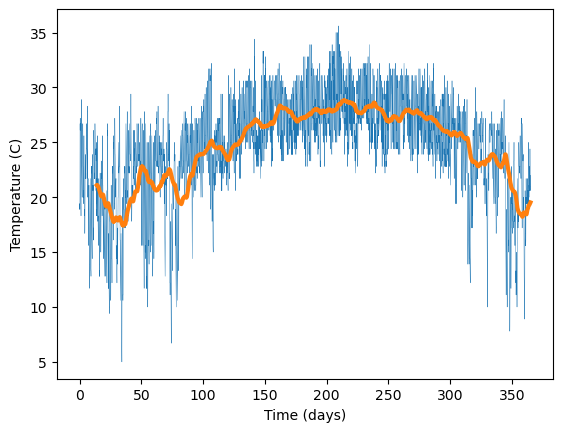

In [2]:
climate = pd.read_csv('climates/hourly_temperature_miami.csv')
climate['t_days'] = climate['t_hours']/24
plt.plot(climate['t_days'], climate['T_degC'], linewidth=0.3)
plt.plot(climate['t_days'], climate['T_degC'].rolling(14*24).mean(), linewidth=3)
plt.xlabel('Time (days)')
plt.ylabel('Temperature (C)')

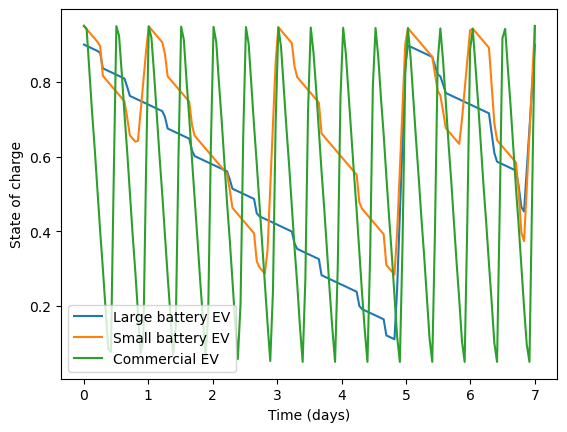

In [3]:
ev_largebattery = pd.read_csv('application profiles/personal_ev_largebatt.csv')
ev_largebattery['t_days'] = ev_largebattery['tsecs'] / (24*3600)
ev_largebattery = ev_largebattery.iloc[np.linspace(0, 24*3600*7 - 1, 24*7)]

ev_smallbattery = pd.read_csv('application profiles/personal_ev_smallbatt.csv')
ev_smallbattery['t_days'] = ev_smallbattery['tsecs'] / (24*3600)
ev_smallbattery = ev_smallbattery.iloc[np.linspace(0, 24*3600*7 - 1, 24*7)]

commercial_ev = pd.read_csv('application profiles/commercial_ev.csv')
commercial_ev['t_days'] = commercial_ev['tsecs'] / (24*3600)
commercial_ev = commercial_ev.iloc[np.linspace(0, 24*3600*7 - 1, 24*7)]

plt.plot(ev_largebattery['t_days'], ev_largebattery['soc'], label='Large battery EV')
plt.plot(ev_smallbattery['t_days'], ev_smallbattery['soc'], label='Small battery EV')
plt.plot(commercial_ev['t_days'], commercial_ev['soc'], label='Commercial EV')
plt.xlabel('Time (days)')
plt.ylabel('State of charge')
plt.legend()

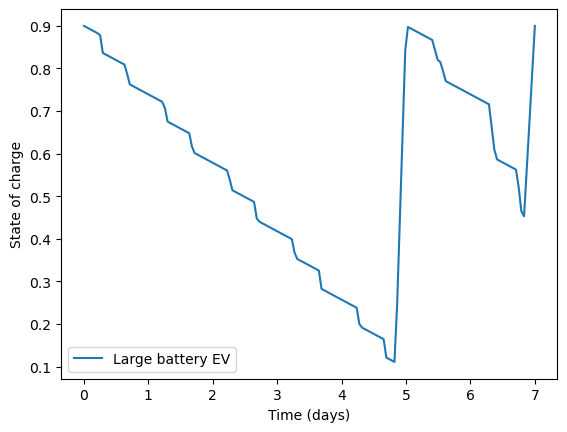

In [4]:
plt.plot(ev_largebattery['t_days'], ev_largebattery['soc'], label='Large battery EV')
plt.xlabel('Time (days)')
plt.ylabel('State of charge')
plt.legend()

In [5]:
input_ev_smallbatt = assemble_one_year_input(ev_smallbattery, climate)
input_ev_largebatt = assemble_one_year_input(ev_largebattery, climate)
input_ev_commercial = assemble_one_year_input(commercial_ev, climate)

c:\Users\pgasper\Documents\GitHub\BLAST-Lite\python\functions\state_functions.py:45: RuntimeWarning: invalid value encountered in log
  x_inv = (1 / k) * ((np.log(-(2 * y_inf/(y0-y_inf)) - 1)) ** (1 / p) )


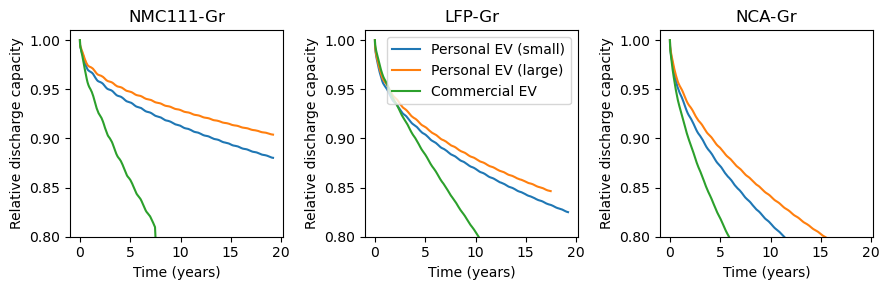

In [6]:
from models.nmc111_gr_Kokam75Ah_2017 import Nmc111_Gr_Kokam75Ah_Battery
from models.lfp_gr_SonyMurata3Ah_2018 import Lfp_Gr_SonyMurata3Ah_Battery
from models.nca_gr_Panasonic3Ah_2018 import Nca_Gr_Panasonic3Ah_Battery

from functions.simulation import simulate_battery_life

batteries = {
    'NMC111-Gr': [Nmc111_Gr_Kokam75Ah_Battery(), Nmc111_Gr_Kokam75Ah_Battery(), Nmc111_Gr_Kokam75Ah_Battery()],
    'LFP-Gr': [Lfp_Gr_SonyMurata3Ah_Battery(), Lfp_Gr_SonyMurata3Ah_Battery(), Lfp_Gr_SonyMurata3Ah_Battery()],
    'NCA-Gr': [Nca_Gr_Panasonic3Ah_Battery(), Nca_Gr_Panasonic3Ah_Battery(), Nca_Gr_Panasonic3Ah_Battery()],
}
simulations = {
    'Personal EV (small)': input_ev_smallbatt,
    'Personal EV (large)': input_ev_largebatt,
    'Commercial EV': input_ev_commercial,
}

years_simulation = 20
fig, ax = plt.subplots(1, 3, figsize=(9,3))
idx_ax = 0
for batt_type, battery in batteries.items():
    idx_sim = 0
    for sim_type, sim_input in simulations.items():
        batt = battery[idx_sim]
        batt = simulate_battery_life(batt, sim_input, years_simulation)

        ax[idx_ax].plot(batt.stressors['t_days']/365, batt.outputs['q'], label=sim_type)
        idx_sim += 1
        
    ax[idx_ax].set_xlabel('Time (years)')
    ax[idx_ax].set_ylabel('Relative discharge capacity')
    ax[idx_ax].set_ylim((0.8, 1.01))
    ax[idx_ax].set_title(batt_type)
    if idx_ax == 1:
        ax[idx_ax].legend(loc='upper right')
    idx_ax += 1

plt.tight_layout()

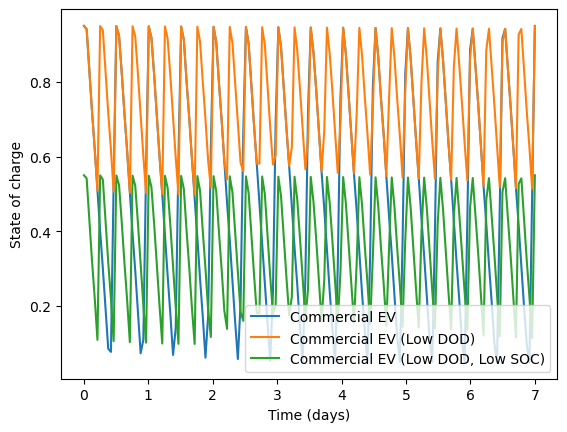

In [7]:
commercial_ev_lowdod = pd.read_csv('application profiles/commercial_ev_lowdod.csv')
commercial_ev_lowdod['t_days'] = commercial_ev_lowdod['tsecs'] / (24*3600)
commercial_ev_lowdod = commercial_ev_lowdod.iloc[np.linspace(0, 24*3600*7 - 1, 24*7)]

commercial_ev_lowdod_lowsoc = commercial_ev_lowdod.copy()
commercial_ev_lowdod_lowsoc['soc'] += -0.4

plt.plot(commercial_ev['t_days'], commercial_ev['soc'], label='Commercial EV')
plt.plot(commercial_ev_lowdod['t_days'], commercial_ev_lowdod['soc'], label='Commercial EV (Low DOD)')
plt.plot(commercial_ev_lowdod_lowsoc['t_days'], commercial_ev_lowdod_lowsoc['soc'], label='Commercial EV (Low DOD, Low SOC)')
plt.xlabel('Time (days)')
plt.ylabel('State of charge')
plt.legend()

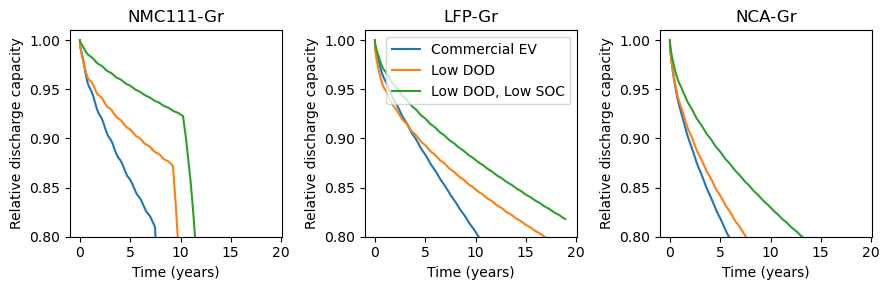

In [8]:
input_ev_commercial_lowdod = assemble_one_year_input(commercial_ev_lowdod, climate)
input_ev_commercial_lowdod_lowsoc = assemble_one_year_input(commercial_ev_lowdod_lowsoc, climate)

batteries = {
    'NMC111-Gr': [Nmc111_Gr_Kokam75Ah_Battery(), Nmc111_Gr_Kokam75Ah_Battery(), Nmc111_Gr_Kokam75Ah_Battery()],
    'LFP-Gr': [Lfp_Gr_SonyMurata3Ah_Battery(), Lfp_Gr_SonyMurata3Ah_Battery(), Lfp_Gr_SonyMurata3Ah_Battery()],
    'NCA-Gr': [Nca_Gr_Panasonic3Ah_Battery(), Nca_Gr_Panasonic3Ah_Battery(), Nca_Gr_Panasonic3Ah_Battery()],
}
simulations = {
    'Commercial EV': input_ev_commercial,
    'Low DOD': input_ev_commercial_lowdod,
    'Low DOD, Low SOC': input_ev_commercial_lowdod_lowsoc,
}

years_simulation = 20
fig, ax = plt.subplots(1, 3, figsize=(9,3))
idx_ax = 0
for batt_type, battery in batteries.items():
    idx_sim = 0
    for sim_type, sim_input in simulations.items():
        batt = battery[idx_sim]
        batt = simulate_battery_life(batt, sim_input, years_simulation)

        ax[idx_ax].plot(batt.stressors['t_days']/365, batt.outputs['q'], label=sim_type)
        idx_sim += 1
        
    ax[idx_ax].set_xlabel('Time (years)')
    ax[idx_ax].set_ylabel('Relative discharge capacity')
    ax[idx_ax].set_ylim((0.8, 1.01))
    ax[idx_ax].set_title(batt_type)
    if idx_ax == 1:
        ax[idx_ax].legend(loc='upper right')
    idx_ax += 1

plt.tight_layout()